In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs

# Set wide fig size for plots
plt.rcParams['figure.figsize']=(12,3)

### Loading in essential custom functions

In [2]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [3]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [5]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )

    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)



    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()
    
    return fig

In [6]:
# Load in stock data
ts = pd.read_csv("Data/WMT.csv", 
                  parse_dates=['Date'], index_col='Date')
ts.head()

,Adj Close
Date,
2000-01-03,44.915394
2000-01-04,43.234756
2000-01-05,42.352402
2000-01-06,42.814564
2000-01-07,46.049828


In [17]:
# We are only using data from 2010 to 2020
ts = ts.loc['2010':'2020', 'Adj Close']
ts

Date
2010-01-01           NaN
2010-01-04     40.963638
2010-01-05     40.555729
2010-01-06     40.465084
2010-01-07     40.487759
                 ...    
2020-12-25           NaN
2020-12-28    142.946777
2020-12-29    142.041183
2020-12-30    141.923065
2020-12-31    141.893524
Freq: B, Name: Adj Close, Length: 2870, dtype: float64

### Make a datetime index using the Date column with a business day frequency ('B')

In [18]:
# Previewing index to ensure it's datetime
ts.index

DatetimeIndex(['2010-01-01', '2010-01-04', '2010-01-05', '2010-01-06',
               '2010-01-07', '2010-01-08', '2010-01-11', '2010-01-12',
               '2010-01-13', '2010-01-14',
               ...
               '2020-12-18', '2020-12-21', '2020-12-22', '2020-12-23',
               '2020-12-24', '2020-12-25', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='Date', length=2870, freq='B')

In [19]:
# Resampling datetime for business days
ts = ts.resample('B').asfreq()
ts

Date
2010-01-01           NaN
2010-01-04     40.963638
2010-01-05     40.555729
2010-01-06     40.465084
2010-01-07     40.487759
                 ...    
2020-12-25           NaN
2020-12-28    142.946777
2020-12-29    142.041183
2020-12-30    141.923065
2020-12-31    141.893524
Freq: B, Name: Adj Close, Length: 2870, dtype: float64

### Check for and address null values.

In [20]:
# Checking nulls
ts.isna().sum()

101

In [21]:
# Inspect null values
null = ts.isna()
ts[null].head(10)

Date
2010-01-01   NaN
2010-01-18   NaN
2010-02-15   NaN
2010-04-02   NaN
2010-05-31   NaN
2010-07-05   NaN
2010-09-06   NaN
2010-11-25   NaN
2010-12-24   NaN
2011-01-17   NaN
Name: Adj Close, dtype: float64

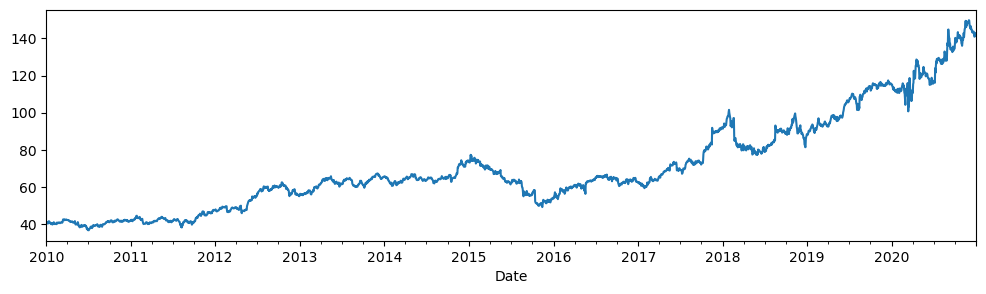

In [22]:
# With holidays as nulls we can forward fill from previous days when price doesn't change
ts = ts.fillna(method='ffill')
ts.plot();

In [24]:
ts.isna().sum()

1

In [25]:
ts.isna()

Date
2010-01-01     True
2010-01-04    False
2010-01-05    False
2010-01-06    False
2010-01-07    False
              ...  
2020-12-25    False
2020-12-28    False
2020-12-29    False
2020-12-30    False
2020-12-31    False
Freq: B, Name: Adj Close, Length: 2870, dtype: bool

In [26]:
ts = ts.fillna(method='bfill')

In [27]:
ts.isna()

Date
2010-01-01    False
2010-01-04    False
2010-01-05    False
2010-01-06    False
2010-01-07    False
              ...  
2020-12-25    False
2020-12-28    False
2020-12-29    False
2020-12-30    False
2020-12-31    False
Freq: B, Name: Adj Close, Length: 2870, dtype: bool

### Check the time series for stationarity.

In [28]:
# Testing the raw data for stationarity
get_adfuller_results(ts)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,1.457375,23,2846,0.99736,0.05,False


### Determine the number of differencing (d) needed to make the data stationary. (We recommend using pmdarima's ndiffs)

In [29]:
# use ndiffs to determine differencing
d = ndiffs(ts)
print(f'd is {d}')

d is 1


In [30]:
# Difference twice (d = 1)
ts_diff1 =ts.diff().dropna()

### Use ACF/PACF plots of the stationary data to estimate initial time series model orders​ (p,d,q)

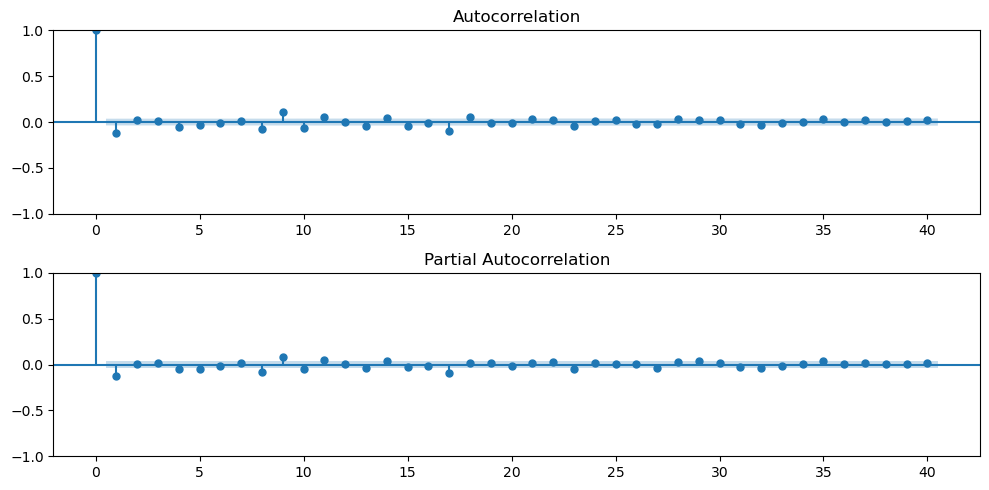

In [31]:
plot_acf_pacf(ts_diff1);

### Split the time series into training and test data. Use a test_size of one quarter (13 weeks X 5 business days)

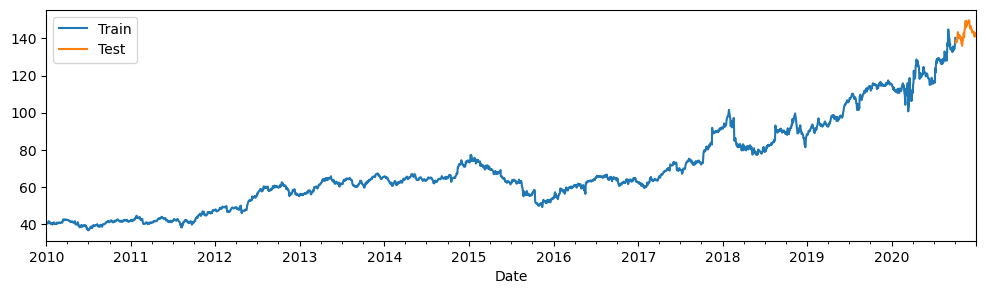

In [32]:
# Calculating number of test lags
n_test_lags = 5*13

# Modeling to predict 6 months into the future
train, test = train_test_split(ts, test_size = n_test_lags)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

### Fit an ARIMA model based on the orders determined during your exploration.

In [33]:
# Building the arima model 
p = 0  # AR component 

d = 1  # Number of differencing required to make stationary

q =  1 # MA component 

# Define and fit the model
arima_model = tsa.ARIMA(train, order=(p,d,q)).fit()

### Make forecasts with your model.

In [34]:
# Obtain summary of forecast as dataframe
forecast_df = arima_model.get_forecast(len(test)).summary_frame()

### Plot the forecasts versus the test data.

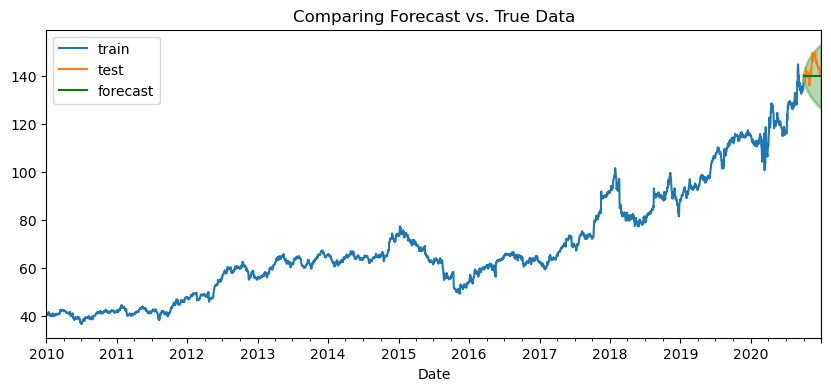

In [36]:
# Plot the forecast with true values
plot_forecast(train, test, forecast_df);

### Obtain metrics for evaluation.

In [37]:
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 3.813
- MSE = 22.964
- RMSE = 4.792
- R^2 = -0.786
- MAPE = 2.62%


### Try at least one variation of the model for comparison (we recommend using a loop to try combinations of model orders)

In [39]:
import itertools

# Define the value or range of values for p, d, q
p_values = range(0, 4)  
d_values = [2]          
q_values = range(0, 4)  

# Create combinations of pdq to test
pdq_to_try = list(itertools.product(p_values, d_values, q_values))
pdq_to_try

[(0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (0, 2, 3),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (1, 2, 3),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2),
 (2, 2, 3),
 (3, 2, 0),
 (3, 2, 1),
 (3, 2, 2),
 (3, 2, 3)]

In [40]:
# define starting aic as infinity
best_aic = float("inf")  

# define baseline for pdq
best_pdq = (0,0,0)

# Loop through each combination
for pdq in pdq_to_try:
    
    model = tsa.ARIMA(train, order=pdq)
                              
    result = model.fit()
    
    print(pdq, result.aic)      
    
    # If lower, replace best AIC with new value
    if result.aic < best_aic:
        
        best_aic = result.aic
        best_pdq = pdq

# Print the best orders and AIC score
print("Best AIC:", best_aic)
print("Best pdq:", best_pdq)

(0, 2, 0) 10070.877815682234
(0, 2, 1) 7823.537120788003
(0, 2, 2) 7785.476488829076
(0, 2, 3) 7786.365532232739
(1, 2, 0) 8999.800284433224
(1, 2, 1) 7784.421455113121
(1, 2, 2) 7786.306060975305


C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 2, 3) 7786.177207802746
(2, 2, 0) 8621.399548628899
(2, 2, 1) 7786.299653004124


C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 2, 2) 7782.980981304956


C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 2, 3) 7790.289149895898
(3, 2, 0) 8472.56223113337
(3, 2, 1) 7788.296639017521


C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 2, 2) 7782.189694485662
(3, 2, 3) 7756.76081641462
Best AIC: 7756.76081641462
Best pdq: (3, 2, 3)


C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [44]:
# Building the arima model 
p = 3  # AR component 

d = 3  # Number of differencing required to make stationary

q = 3 # MA component 

# Define and fit the model
arima_model = tsa.ARIMA(train, order=(p,d,q)).fit()

C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [45]:
# Obtain summary of forecast as dataframe
forecast_df = arima_model.get_forecast(len(test)).summary_frame()

In [46]:
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 2.646
- MSE = 10.209
- RMSE = 3.195
- R^2 = 0.206
- MAPE = 1.84%


### A MAPE of less than 2% on the test data is achievable.

### Choose a final model and explain:
- How good was your model, according to your Mean Absolute Percentage Error? **MAPE at 1.84%**
- How good was your model in terms of how well the forecast seems to follow the test data, visually?  (Hint: You may want to plot fewer training data lags to see this)

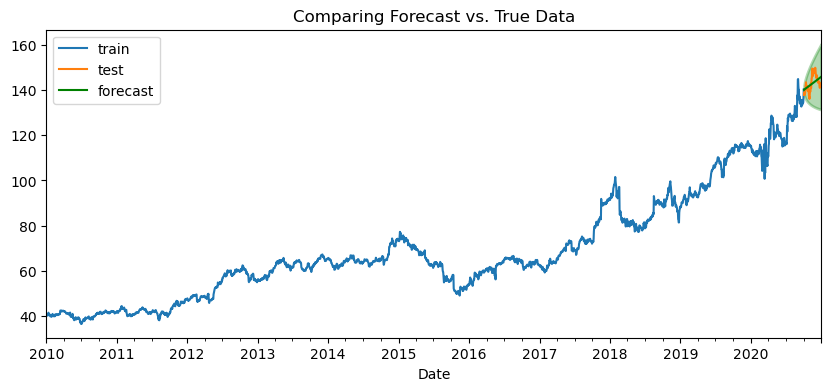

In [52]:
# Plot the forecast with true values
plot_forecast(train, test, forecast_df);

### The trend lines up with testing albeit with big variance.